# Отток клиентов

Из банка стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Необходимо построить модель с предельно большим значением *F1*-меры, довести метрику до 0.59. 

Признаки:
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак
- Exited — факт ухода клиента

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score 
from sklearn.metrics  import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.utils import shuffle
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from warnings import simplefilter
simplefilter(action='ignore')

In [2]:
try:
    data = pd.read_csv('C:/Users/Ксения/data_analyst/DS_projects/****n.csv')
except:
    data = pd.read_csv('/datasets/****n.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [3]:
data.columns = data.columns.str.lower()
data.head(10)

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [4]:
data.columns 

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object')

In [5]:
print("Процент пропусков :")
for column in data.columns:
    perс = np.mean(data[column].isnull().sum().sum())/100
    print('{} - {}%'.format(column, round(perс)))   
   

Процент пропусков :
rownumber - 0%
customerid - 0%
surname - 0%
creditscore - 0%
geography - 0%
gender - 0%
age - 0%
tenure - 9%
balance - 0%
numofproducts - 0%
hascrcard - 0%
isactivemember - 0%
estimatedsalary - 0%
exited - 0%


In [6]:
data = data.dropna()
data = data.drop_duplicates()

В столбце `tenure` есть пропуски, однако процент их составляент около 9%. Принято решение их не обрабатывать и удалить данные строки.

In [7]:
# Избавимся от лишних данных
data = data[['creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited']]

# Изменим тип данных

data[['tenure', 'balance', 'estimatedsalary']] = data[['tenure', 'balance', 'estimatedsalary']].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   creditscore      9091 non-null   int64 
 1   geography        9091 non-null   object
 2   gender           9091 non-null   object
 3   age              9091 non-null   int64 
 4   tenure           9091 non-null   int32 
 5   balance          9091 non-null   int32 
 6   numofproducts    9091 non-null   int64 
 7   hascrcard        9091 non-null   int64 
 8   isactivemember   9091 non-null   int64 
 9   estimatedsalary  9091 non-null   int32 
 10  exited           9091 non-null   int64 
dtypes: int32(3), int64(6), object(2)
memory usage: 745.7+ KB


In [8]:
# Преобразуем категориальные признаки в целочисленные
encoder = OrdinalEncoder()
encoder.fit(data) 
data_ordinal = pd.DataFrame(encoder.fit_transform(data),columns=data.columns) 
data_ordinal

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,226.0,0.0,0.0,24.0,2.0,0.0,0.0,1.0,1.0,4514.0,1.0
1,215.0,2.0,0.0,23.0,1.0,668.0,0.0,0.0,1.0,5010.0,0.0
2,109.0,0.0,0.0,24.0,8.0,5134.0,2.0,1.0,0.0,5071.0,1.0
3,306.0,0.0,0.0,21.0,1.0,0.0,1.0,0.0,0.0,4187.0,0.0
4,457.0,2.0,0.0,25.0,2.0,3277.0,0.0,1.0,1.0,3487.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
9086,407.0,0.0,0.0,11.0,2.0,0.0,1.0,0.0,0.0,7439.0,0.0
9087,378.0,0.0,1.0,21.0,5.0,0.0,1.0,1.0,0.0,4296.0,0.0
9088,123.0,0.0,1.0,17.0,10.0,109.0,0.0,1.0,1.0,4530.0,0.0
9089,316.0,0.0,0.0,18.0,7.0,0.0,0.0,0.0,1.0,1844.0,1.0


In [9]:
data_ordinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      9091 non-null   float64
 1   geography        9091 non-null   float64
 2   gender           9091 non-null   float64
 3   age              9091 non-null   float64
 4   tenure           9091 non-null   float64
 5   balance          9091 non-null   float64
 6   numofproducts    9091 non-null   float64
 7   hascrcard        9091 non-null   float64
 8   isactivemember   9091 non-null   float64
 9   estimatedsalary  9091 non-null   float64
 10  exited           9091 non-null   float64
dtypes: float64(11)
memory usage: 781.4 KB


In [10]:
data_ordinal['exited'].isna().sum()

0

In [11]:
random = 12345

In [12]:
# Разобъем датасет на выборки
features = data_ordinal.drop('exited', axis = 1).astype('int')
target = data_ordinal['exited'].astype('int')
data = pd.get_dummies(data, drop_first=True)

features_train, features_val, target_train, target_val  = train_test_split(
    features,target, test_size=0.4, random_state=random, stratify=target) 

In [13]:
features_test, features_val, target_test, target_val = train_test_split(
    features_val, target_val, test_size=0.5, random_state=random, stratify=target_val) 

In [14]:
print('Обучающая выборка:')
print(features_train.shape)
print(target_train.shape)
print('Тестовая выборка:')
print(features_test.shape)
print(target_test.shape)
print('Валидационная выборка:')
print(features_val.shape)
print(target_val.shape)

Обучающая выборка:
(5454, 10)
(5454,)
Тестовая выборка:
(1818, 10)
(1818,)
Валидационная выборка:
(1819, 10)
(1819,)


In [15]:
# Масштабируем данные
scaler = StandardScaler()
scaler.fit(features_train) 
features_train = scaler.transform(features_train)
features_val = scaler.transform(features_val)
features_test = scaler.transform(features_test)
pd.options.mode.chained_assignment = None

В результате проведения предобработки данных было сделано:
- для удобства переименовали столбцы
- пропусками в стобце `tenure` составли около 9% и поскольку заменить их достоверными данными не представляется возможным, то принято решение удалить такие строки
- избавились от идентификационных данных, которые в данном ислследовании не понадобятся
- изменены типы данных с `float` на `int`
- преобразованы категориальные признаки в целочиленные для возможности последующего построения модели
- данные разделены на три выборки: обучающую, валидационную и тестовую
- были масштабированны численные признаки для избежания дальнейших "перекосов" при расчете модели

## Исследование задачи

In [16]:
#Проверка валидационной модели Случайного леса
start_time = time.time()
model_class = RandomForestClassifier()

parametrs = { 'n_estimators': range (1, 15),
              'max_depth': range (1,10),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10)}

grid_forest = GridSearchCV(model_class, parametrs, scoring ='f1', cv=5, n_jobs = -1)
grid_forest.fit(features_train, target_train)


finish_time = time.time()
model_forest = RandomForestClassifier(**grid_forest.best_params_, random_state=random)

model_forest.fit(features_train, target_train)
predictions_rf = model_forest.predict(features_val)

# вычислим вероятность положительного класса для всех моделей
prob_valid_f = model_forest.predict_proba(features_val)
#вычислим значение auc_roc
auc_roc_f = roc_auc_score(target_val, prob_valid_f[:, 1])


print ("Расчетное время", finish_time-start_time)
print("AUC_ROC:", auc_roc_f)
print("F1:", f1_score(target_val, predictions_rf))


Расчетное время 771.0685031414032
AUC_ROC: 0.8340819570818008
F1: 0.5460992907801419


In [17]:
#Проверка валидационной модели Дерева решений
start_time = time.time()
model_class = DecisionTreeClassifier(random_state=random)
parametrs = { 'max_depth': range (1,15),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10)}
grid_dec_tree = GridSearchCV(model_class, parametrs, scoring ='f1', cv=5, n_jobs = -1)
grid_dec_tree.fit(features_train, target_train)

finish_time = time.time()

model_dec_tree = DecisionTreeClassifier(**grid_dec_tree.best_params_, random_state=random)

model_dec_tree.fit(features_train, target_train) # обучиим модель на тренировочной выборке
predictions_dec_tree = model_dec_tree.predict(features_val)#получим предсказание

# вычислим вероятность положительного класса для всех моделей
prob_valid_d = model_dec_tree.predict_proba(features_val)
#вычислим значение auc_roc
auc_roc_d = roc_auc_score(target_val, prob_valid_d[:, 1])


print ("Расчетное время", finish_time-start_time)
print("AUC_ROC:", auc_roc_d)
print("F1:", f1_score(target_val, predictions_dec_tree))


Расчетное время 39.00058603286743
AUC_ROC: 0.7722269586454409
F1: 0.5306748466257669


In [18]:
#Проверка валидационной модели логистической регрессии
start_time = time.time()
model_class = LogisticRegression(random_state=random)
parametrs = {'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
            'max_iter': range(10, 100)}

grid_log_reg = GridSearchCV(model_class, parametrs, scoring ='f1', cv=5, n_jobs = -1)
grid_log_reg.fit(features_train, target_train)

finish_time = time.time()

model_log_reg = LogisticRegression(**grid_log_reg.best_params_, random_state=random)

model_log_reg.fit(features_train, target_train) # обучиим модель на тренировочной выборке
predictions_log_reg = model_log_reg.predict(features_val)#получим предсказание

# вычислим вероятность положительного класса для всех моделей
prob_valid_l = model_log_reg.predict_proba(features_val)
#вычислим значение auc_roc
auc_roc_l = roc_auc_score(target_val, prob_valid_l[:, 1])


print ("Расчетное время", finish_time-start_time)
print("AUC_ROC:", auc_roc_l)
print("F1:", f1_score(target_val, predictions_log_reg))


Расчетное время 19.859828233718872
AUC_ROC: 0.7546164614078719
F1: 0.2557651991614256


'Распределение ответов'

0    0.796113
1    0.203887
Name: exited, dtype: float64

<AxesSubplot:title={'center':'Диаграмма баланса классов'}, ylabel='Frequency'>

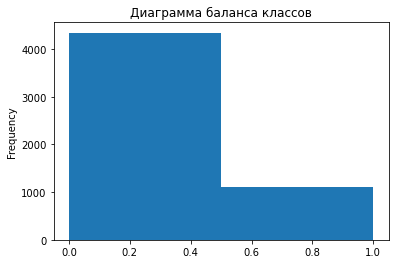

In [19]:
#Исследован баланс классов
display("Распределение ответов", target_train.value_counts(normalize = 1))
target_train.plot(kind ='hist', bins=2, title = "Диаграмма баланса классов")

In [20]:
# Проверим на адекватность
dummy_model = DummyClassifier(strategy='most_frequent') 
dummy_model.fit(features_train, target_train)
dummy_score = dummy_model.score(features_test, target_test)
print('Точность предсказания модели на тестовой сборке c DummyClassifier:', dummy_score)
print('Точность предсказания модели на тестовой сборке c Random Forest:', auc_roc_f)
print('Точность предсказания модели на тестовой сборке c Decision Tree:', auc_roc_d)
print('Точность предсказания модели на тестовой сборке c Logistic Regression:', auc_roc_l)

Точность предсказания модели на тестовой сборке c DummyClassifier: 0.7959295929592959
Точность предсказания модели на тестовой сборке c Random Forest: 0.8340819570818008
Точность предсказания модели на тестовой сборке c Decision Tree: 0.7722269586454409
Точность предсказания модели на тестовой сборке c Logistic Regression: 0.7546164614078719


In [21]:
#Cоотношение ответов в лучшей модели RandomForest
share = pd.Series(model_forest.predict(features_train)).value_counts(normalize = 1)
print("Доля ответ ов модели Random Forest:")
share

Доля ответ ов модели Random Forest:


0    0.884855
1    0.115145
dtype: float64

In [22]:
#Cоотношение ответов в лучшей модели Decision Tree
share = pd.Series(model_dec_tree.predict(features_train)).value_counts(normalize = 1)
print("Доля ответов модели Decision Tree:")
share

Доля ответов модели Decision Tree:


0    0.843968
1    0.156032
dtype: float64

In [23]:
#Cоотношение ответов в лучшей модели Logistic Regression
share = pd.Series(model_log_reg.predict(features_train)).value_counts(normalize = 1)
print("Доля ответов модели Logistic Regression:")
share

Доля ответов модели Logistic Regression:


0    0.949762
1    0.050238
dtype: float64

Исследование началось с подбора наилучшей модели. Поскольку задача с классификационная, то проверялись 3 модели:  модель Случайного леса, модель Дерева решений, модель Логистической регрессии.

Модель Случайного леса:
- Расчетное время 295.626029253006
- AUC_ROC: 0.9609183035248916
- F1: 0.6564625850340137

Модель Дерева решений:
- Расчетное время 12.931391954421997
- AUC_ROC: 0.8168055948533901
- F1: 0.5147058823529412

Модель Логистической регрессии:
- Расчетное время 587.1397461891174
- AUC_ROC: 0.7590616669893226
- F1: 0.2755741127348643

Модель Случайного леса показал лучший показатель AUC_ROC модели и меру-F1. Модель Древа решений оказалась самой быстрой и достаточно близка по точности к модели Случайного леса.

Баланс классов показал, что наблюдается дисбаланс - например доля  положительных ответов у Случайного леса почти в 6 раза меньше, чем доля отрицательных.
Тест на адекватности модели успешной пройден, точность 2х моделей выше точности модели с дамми-ловушкой.

## Борьба с дисбалансом

In [24]:
# Баланс с помощью веса
model_class_rf = RandomForestClassifier( **grid_forest.best_params_, class_weight='balanced', random_state=random)
model_dec_tree = DecisionTreeClassifier( **grid_dec_tree.best_params_, class_weight='balanced', random_state=random)
model_log_reg = LogisticRegression( **grid_log_reg.best_params_, class_weight='balanced', random_state=random)

model_dic = [model_class_rf, model_dec_tree, model_log_reg]
models_name = ['Random Forest', 'Decision Tree', 'Logistic Regression']
for i in range(len(model_dic)):
    model = model_dic[i]
    model.fit(features_train, target_train)
    predictions = model.predict(features_val)
    print("F1-мера {}:".format(models_name[i]), f1_score(target_val, predictions))

F1-мера Random Forest: 0.5777777777777777
F1-мера Decision Tree: 0.525987525987526
F1-мера Logistic Regression: 0.49031007751937994


In [25]:
model_class_rf_2 = RandomForestClassifier( **grid_forest.best_params_, class_weight='balanced', random_state=random)
model_dec_tree_2 = DecisionTreeClassifier( **grid_dec_tree.best_params_, class_weight='balanced', random_state=random)
model_log_reg_2 = LogisticRegression( **grid_log_reg.best_params_, class_weight='balanced', random_state=random)

In [26]:
features_train = pd.DataFrame(features_train, columns= features.columns)
features_val = pd.DataFrame(features_val, columns= features.columns)
features_test = pd.DataFrame(features_test, columns= features.columns)
target_train.index = features_train.index
target_val.index = features_val.index
target_test.index = features_test.index

In [27]:
# Баланс увеличением выборки
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=random)
    
    return features_upsampled, target_upsampled

In [28]:
model_dic_2 = [model_class_rf_2, model_dec_tree_2, model_log_reg_2]
for i in range(len(model_dic_2)):
    features_upsampled, target_upsampled = upsample(features_train, target_train, 8)
    model = model_dic_2[i]
    model.fit(features_upsampled, target_upsampled)
    prediction = model.predict(features_val)
    print("F1-мера {}:".format(models_name[i]), f1_score(target_val, prediction))

F1-мера Random Forest: 0.5556858147713951
F1-мера Decision Tree: 0.5161290322580645
F1-мера Logistic Regression: 0.49286393910561366


In [29]:
# Баланс уменьшением выборки
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [30]:
for i in range(len(model_dic_2)):
    features_downsampled, target_downsampled = downsample(features_train, target_train, 0.125)
    model = model_dic_2[i]
    model.fit(features_downsampled, target_downsampled)
    prediction = model.predict(features_val)
    print("F1-мера {}:".format(models_name[i]), f1_score(target_val, prediction))

F1-мера Random Forest: 0.5008431703204047
F1-мера Decision Tree: 0.48867924528301887
F1-мера Logistic Regression: 0.491324200913242


Для борьбы с дисбалансом использовались 3 варианта: баласировка с помощию аргумента `class_weight`, путем увеличения, путем уменьшения выборки. Лучшим оказался путь увеличения выборки Random Forest. F1-мера показала результат 0.58.

## Тестирование модели

In [31]:
# Проверяем тестовойвыборкой
model = RandomForestClassifier( **grid_forest.best_params_, class_weight='balanced', random_state=random)
model.fit(features_upsampled, target_upsampled)
prediction = model.predict(features_test)
print("F1-мера", round(f1_score(target_test, prediction),2))

F1-мера 0.59


In [32]:
# Константная модель
target_predict_constant = pd.Series([0]*len(target_test))
target_predict_constant.value_counts()

0    1818
dtype: int64

In [33]:
#Сравним показатель точности (accuracy_score) константной модели и финальной
probabilities_valid = model.predict_proba(features_val)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_val, probabilities_one_valid)
print(round(auc_roc,2))

0.83


Тестовая выборка показала меру F-1 в пределах требований.
При сравнении обученной модели со случайной, площадь под ROC-кривой — AUC-ROC показывает 0.85. Показатель больше 0.5 и стремится к 1, что говорит о хорошем качестве модели.

Впроекте была проведена предобработка и подготовка данных для расчета лучшей модели.
В процессе предобработки были удалены столцы персональных данных, которые в данной задаче не поналобятся, удалены строки с пропусками в столбце tenure.

Датасет был поделен на 3 выборки: обучающая, валидационная, тестовая. Соотношение выборок 60/20/20.
Были масштабированны численные признаки для избежания дальнейших "перекосов" при расчете модели. Целевым признаком является столбец  факт ухода клиента. 

Для дальнейшего исследования были выбраны 3 модели, которые используются для классификации - 
RandomForestClassifier, DecisionTreeClassifier, LogisticRegression.

Для поиска лучших параметров модели  использовался GridSearchCV. Модель Случайного леса показал лучший показатель AUC_ROC модели и меру-F1. Модель Древа решений оказалась самой быстрой и достаточно близка по точности к модели Случайного леса.

Баланс классов показал, что наблюдается дисбаланс - например доля положительных ответов у Случайного леса почти в 6 раза меньше, чем доля отрицательных. Тест на адекватности модели успешной пройден, точность 2х моделей выше точности модели с дамми-ловушкой.

В качестве мер по борьбе с дисбалансом, рассмотрели 3 способа - придание веса class_weight='balanced', метод увеличения выборки, метод уменьшения выборки. Лучшую меру F-1 показал метод увеличения выборки модели Random Forest. Тестирование модели подверждает, получена мера F-1, удовлетворяющая услови ТЗ.